# Random Vortex Method and Linear Remeshing Strategy

The following notebook is about implementation of Random vortex method and compare the vorticity distribution with exact solution using linear remeshing strategy.

In [100]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Vorticity Distribution

In [101]:
def random_vortex_method(nu, mu, dt, position, N):
    sigma = np.sqrt(2*nu*dt)
    x = np.random.normal(mu, sigma, N)
    y = np.random.normal(mu, sigma, N)
    z1 = [position] * N
    z = z1 + x + 1j*y
    return np.asarray(z)

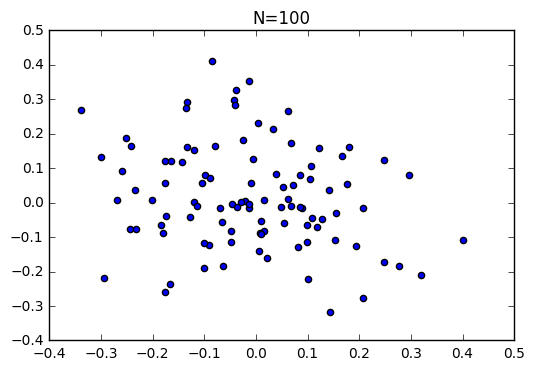

In [102]:
z = random_vortex_method(0.1, 0.0, 0.1, 0+0*1j, 100)
plt.scatter(z.real, z.imag)
plt.title('N=100')
plt.show()

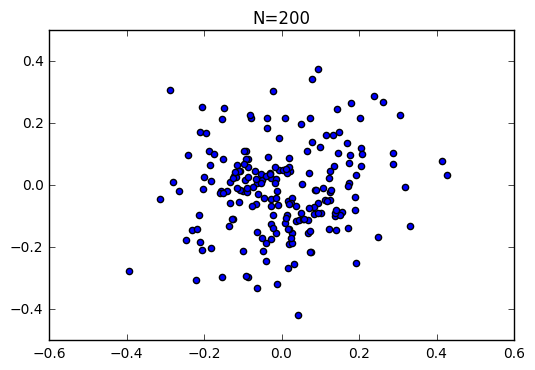

In [103]:
z = random_vortex_method(0.1, 0.0, 0.1, 0+0*1j, 200)
plt.scatter(z.real, z.imag)
plt.title('N=200')
plt.show()

## Grid Generation

In [104]:
def generate_mesh(n_grid, x_min=-2.0, x_max=2.0, y_min=-2.0, y_max=2.0):
    h = (x_max - x_min)/(n_grid-1)
    x_grid, y_grid = np.mgrid[x_min:x_max:n_grid*1j,y_min:y_max:n_grid*1j]
    z_grid = x_grid + 1j*y_grid
    return z_grid, h

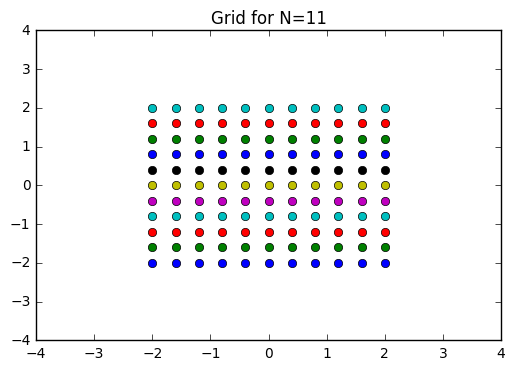

In [105]:
z,h = generate_mesh(11)
plt.plot(z.real, z.imag, 'o')
plt.axis([-4,4,-4,4])
plt.title('Grid for N=11')
plt.show()

## Linear Remeshing Strategy

In [106]:
def remesh(position, n_pt, gamma, factor=8):
    n_grid = factor*n_pt
    z_grid, h= generate_mesh(n_grid)
    gamma_vertex = np.zeros([n_grid,n_grid])
    for zp in position:
        for i,x in enumerate(z_grid.real[:,0]):
            if abs(zp.real-x) < h:
                break
        for j,y in enumerate(z_grid.imag[0]):
            if abs(zp.imag-y) < h:
                break
        delta_x = zp.real - x
        delta_y = zp.imag - y
        if i<n_grid-1 and j<n_grid-1:
            gamma_vertex = gamma_distribution(gamma, gamma_vertex, i, j, delta_x, delta_y, h)
        return gamma_vertex, z_grid, n_grid, h

In [107]:
def gamma_distribution(gamma, gamma_vertex, i, j, delta_x, delta_y, h):
    gamma_vertex[i,j] = (h-delta_x)*(h-delta_y)*gamma
    gamma_vertex[i+1,j] = (delta_x)*(h-delta_y)*gamma
    gamma_vertex[i+1,j+1] = (delta_x)*(delta_y)*gamma
    gamma_vertex[i,j+1] = (h-delta_x)*(delta_y)*gamma
    return gamma_vertex

The exact solution for a point vortex placed at origin is given by $\frac{1}{4 \pi \nu t} e^{-r^2/(4\nu t)}$

In [108]:
def exact_solution(rvm_gamma_vertex, n_grid, z_grid, nu, t, h):
    gamma_vertex = np.zeros([n_grid,n_grid])
    for i in range(n_grid):
        for j in range(n_grid):
            if rvm_gamma_vertex[i][j] != 0.0:
                gamma_vertex[i][j] = (1.0/(4*np.pi*nu*t))* \
                np.exp(-(abs(z_grid[i][j]))**2/(4*nu*t))*h**2
    return gamma_vertex


In [109]:
def vortex_distribution(nu, mu, t, gamma_blob):
    n_list = [10, 20, 30, 50, 70, 100, 150]
    Error = []
    for n in n_list:
        init_position = 0.0
        final_position_array = random_vortex_method(nu, mu, t, init_position, n)
        gamma = gamma_blob/n
        rvm_gamma_vertex, z_grid, n_grid, h = remesh(final_position_array, n, gamma)
        exact_gamma_vertex = exact_solution(rvm_gamma_vertex, n_grid, z_grid, nu, t, h)
        Error.append(np.sum(abs(rvm_gamma_vertex - exact_gamma_vertex))/(n*4))
    plt.semilogx(n_list, Error)
    plt.title('Average Error vs No. of vortices')
    plt.xlabel('No. of Vortices')
    plt.ylabel('Average Error')
    plt.show()

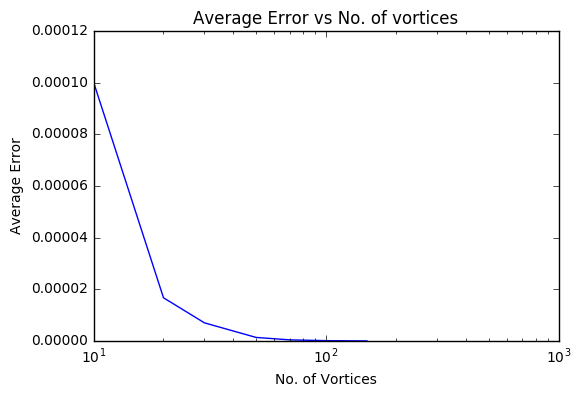

In [110]:
vortex_distribution(nu=0.1, mu=0.0, t=1.0, gamma_blob=1.0)